In [23]:
import os
import shutil
import numpy as np
from glob import glob
import numpy.linalg as la
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage import color
from skimage.util import random_noise
from sklearn.decomposition import PCA
from sklearn.datasets import load_sample_images

Background subtraction is one of the most widely used applications in compute vision. As the name suggests, the goal is to separate the background from the foreground given a sequence of images, which are typically video frames. For example, one can apply the technique to detect moving people or monitor traffic with a surveillance camera. Some cooler applications include digital forensics and human pose estimation.

There are many ways to approach the problem. One simple idea you can think of is to compare adjacent images in the sequence of frames, apply a mean or median filter to estimate the background, and subtract it from every frame to detect moving objects. The approach is really fast and easy to implement, but it doesn't give very good results when the objects are moving fast and the frame rate is slow, for instance. In this study, we approach the problem from another perspective, which leverages convex optimization solvers.

### Principal Component Pursuit
Let's formulate the problem first. If you represent an input image by a long column vector and put one next to another, you get a sizable matrix $\mathbf{M}$ for the whole sequence of video frames. Since the backgrounds and the foregrounds have the same size as the input images, each component is represented by a matrix of the same dimensions. The backgrounds probably don't change much over frames, so each row of the background matrix $\mathbf{L}$ is very similar to each other, making it low-rank. The foreground matrix $\mathbf{S}$, on the other hand, contains moving objects that comprise a small part of input images, and therefore it remains quite sparse. The problem becomes a matrix decomposition with a natural Lagrangian formulation as
\\[ \min_{\mathbf{L}, \; \mathbf{S}} \; \; \text{rank}(\mathbf{L}) + \lambda \|\mathbf{S} \|_0 \ \, \text{ subject to } \; \mathbf{L} + \mathbf{S} = \mathbf{M}. \label{rank-l0} \\]

Unfortunately, the above problem is an intractable problem; both the rank operator and the $\ell_0$ norm are non-convex functions. If we instead use the $\ell_2$ norm, the resulting problem can be written as
\\[ \min_{\mathbf{L}} \; \; \|\mathbf{M} - \mathbf{L}\|_2 \ \, \text{ subject to } \; \text{rank}(\mathbf{L}) \leq k,\label{pca} \\]
with the constant $k$ specified explicitly. The new objective function is still non-convex, but there is a closed-form solution for the new problem, which is just another form of  classical [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), the solution of which is neatly derived via the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition). PCA works great if the noise $\mathbf{M} - \mathbf{L}$ is small in magnitude and normally distributed. However, it is known that even a single grossly corrupted observation can render the estimated low-rank matrix $\hat{\mathbf{L}}$ arbitrarily far from the truth $\mathbf{L}_0$ (see [Figure 1](#fig:pca-noise)).

As we know, such a sensitivity to outliers comes from the $\ell_2$ norm in the objective function. It is therefore natural to think about $\ell_1$ norm, although we have to give up the compact closed-form solution consequently. To make it into the framework of convex optimization, we then use a convex surrogate of the rank operator to obtain another problem often known as principle component pursuit (PCP):
\\[ \text{minimize} \; \|\mathbf{L}\|_* + \lambda \|\mathbf{S}\|_1 \; \text{ subject to } \; \mathbf{L} + \mathbf{S} = \mathbf{M}, \label{pcp} \\]
where $\|\mathbf{L}\|_* = \sum_i \sigma_i(\mathbf{L})$ denotes the [nuclear norm](https://en.wikipedia.org/wiki/Singular_value_decomposition#Ky_Fan_norms) of the low-rank component and $\mathbf{L}$ and $\|\mathbf{S}\|_1 =  \sum_{ij}|\mathbf{S}_{ij}|$ denotes the $\ell_1$ norm of the sparse component
 $\mathbf{S}$ as a long vector. When the true low-rank component $\mathbf{L}_0$ has reasonably spread out  principal components and the true sparse component $\mathbf{S}_0$ is uniformly distributed, it can be proved that PCP perfectly recovers the underlying decomposition of $\mathbf{M}$ [(Candes et al., 2011)](#candes). This is a remarkable result because unlike classical PCA, the exact recovery is guaranteed regardless of the magnitude of entries in $\mathbf{S}_0$. Consequently, the principle component anayslis formulation in yields a more robust low-dimensional estimation of $\mathbf{M}$, and the method is therefore referred to as [robust principal component analysis](https://en.wikipedia.org/wiki/Robust_principal_component_analysis).

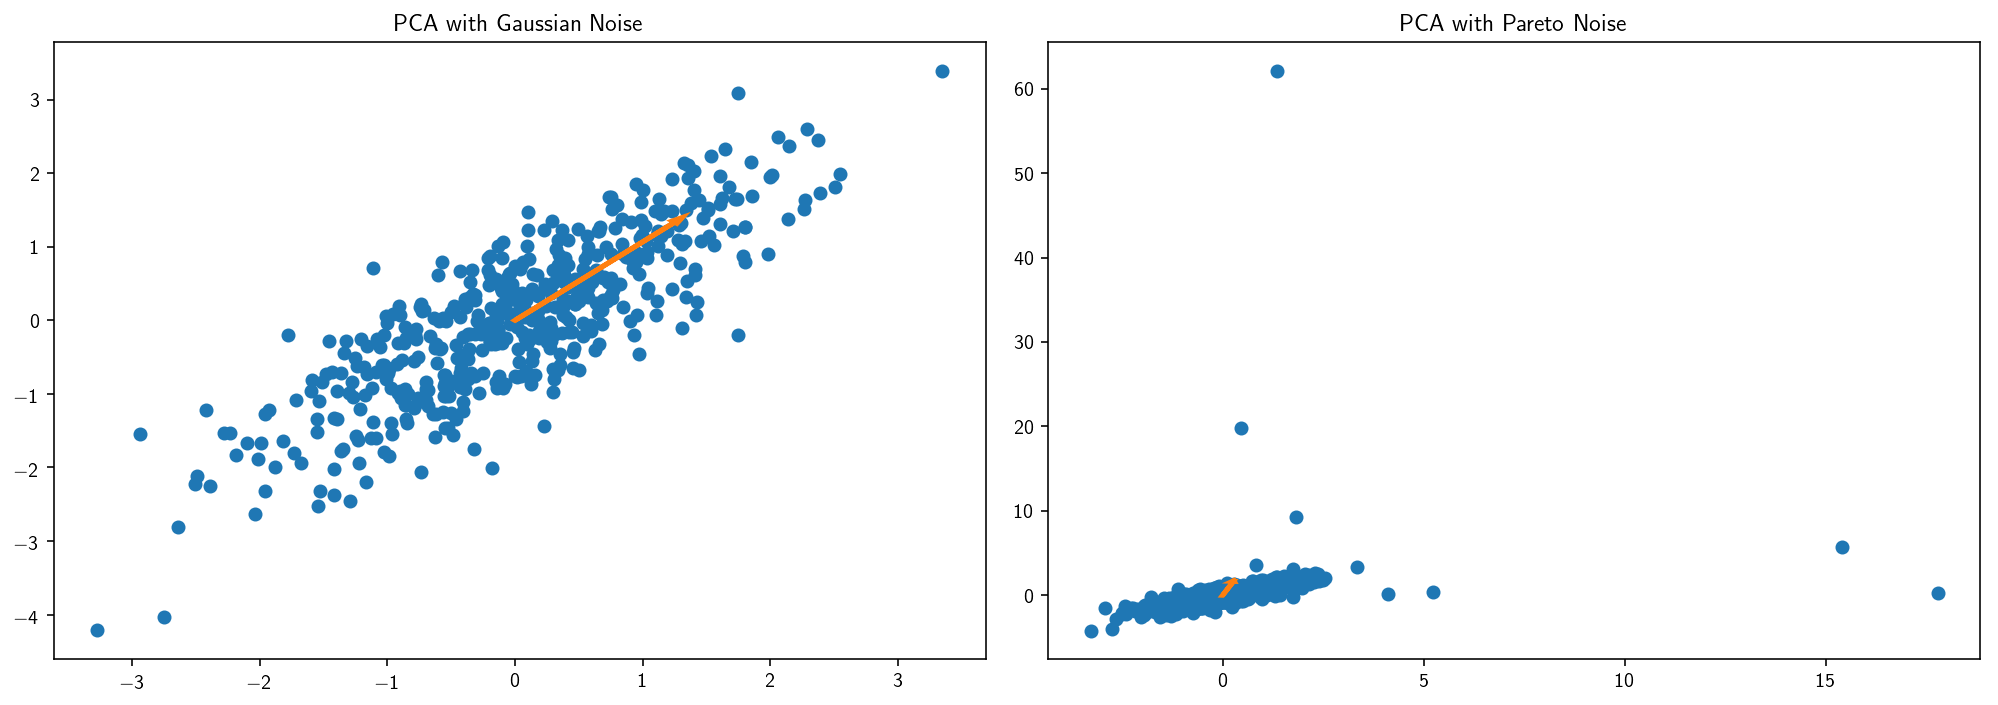

In [72]:
# Toy example to show that PCA is sensitive to outliers
X = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.8], [0.8, 1]], size=500)
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1])
pcax = PCA(n_components=2)
pcax.fit(X)
coords = 2 * np.sign(pcax.components_[0, 0]) * pcax.components_ * pcax.explained_variance_ratio_[:, None]
plt.arrow(0, 0, coords[0, 0], coords[0, 1], head_width=0.05, head_length=0.09, linewidth=2.5, color='C1')
plt.title('PCA with Gaussian Noise')

Y = np.stack((np.random.pareto(a=1, size=10), np.random.pareto(a=1, size=10)), axis=1)
Z = np.concatenate((X, Y), axis=0)
plt.subplot(1, 2, 2)
plt.scatter(Z[:, 0], Z[:, 1])
pcaz = PCA(n_components=2)
pcaz.fit(Z)
coords = 2 * np.sign(pcaz.components_[0, 0]) * pcaz.components_ * pcaz.explained_variance_ratio_[:, None]
plt.arrow(0, 0, coords[0, 0], coords[0, 1], head_width=0.05, head_length=0.09, linewidth=2.5, color='C1')
plt.title('PCA with Pareto Noise')
plt.tight_layout()
fig.savefig('/Users/btang/Desktop/blog/assets/posts/robust-pca/pca-noise.png', bbox_inches='tight', dpi=300)

 The left figure shows a dataset of 500 observations from a multivariate normal distribution, whose covariance matrix has $(\sqrt{2}, \sqrt{2})^\mathsf{T}$ as the eigenvector corresponding to the largest eigenvalue. The estimated principle component denoted by the orange vector in the left figure is( $(0.7135, 0.7006)^\mathsf{T}$, which is very close to the ground truth. However, when 10 additional observations drawn from a heavy-tailed distribution are added, the estimated vector shifts drastically towards the noisy observations and becomes $(0.9190, 0.3943)^{\mathsf{T}}$ as shown in the right figure. Robust PCA, however, remains effective for this dataset, returning $(0.6967, 0.7173)^\mathsf{T}$ for the estimated low-rank component. The example shows that PCA is very sensitive to even a small number of outliers.

### Augmented Lagrange Multipliers
Now that we have a convex optimization problem using principle component pursuit, how should we go about solving it? One effective way to solve PCP is via [augmented Lagrangian multiplier](https://en.wikipedia.org/wiki/Augmented_Lagrangian_method). This method consists of defining the augmented Lagrangian function
\\[ \ell(\mathbf{L}, \mathbf{S}, \mathbf{Y}) = \|\mathbf{L}\|_* + \lambda \|\mathbf{S}\|_1 + \langle \mathbf{Y}, \mathbf{M} - \mathbf{L} - \mathbf{S} \rangle + \frac{\mu}{2} \|\mathbf{M} - \mathbf{L} - \mathbf{S}\|_F^2,\label{alm} \\]
where $\langle \mathbf{X}, \mathbf{Y} \rangle = \text{Trace}(\mathbf{X}^\mathsf{T} \mathbf{Y})$, and then iteratively minimizing it by setting $(\mathbf{L}_{k}, \mathbf{S}_{k}) = \text{argmin}_{(\mathbf{L}, \, \mathbf{S})} \ell(\mathbf{L}, \mathbf{S}, \mathbf{Y}_{k})$ and updating $\mathbf{Y}_{k + 1} = \mathbf{Y}_{k} + \mu(\mathbf{M} - \mathbf{L}_{k} - \mathbf{S}_{k})$. [Lin et al. (2010)](#lin) notes that we can avoid solving the augmented Lagragian function and use an alternative optimization approach simply because both $\text{argmin}_{\mathbf{L}} \; \ell(\mathbf{L}, \mathbf{S}, \mathbf{Y}_{k})$ and $\text{argmin}_{\mathbf{S}}\; \ell(\mathbf{L}, \mathbf{S}, \mathbf{Y}_{k})$ have closed form solutions:
\\[\begin{align}\text{argmin}_{\mathbf{L}} \; \ell(\mathbf{L}, \mathbf{S}, \mathbf{Y}_{k}) &= \mathcal{S}_{\lambda \mu^{-1}} (\mathbf{M} - \mathbf{L} + \mu^{-1}\mathbf{Y}), \\ \text{argmin}_{\mathbf{S}} \; \ell(\mathbf{L}, \mathbf{S}, \mathbf{Y}_{k}) &= \mathcal{D}_{\mu^{-1}} (\mathbf{M} - \mathbf{S} + \mu^{-1}\mathbf{Y}).
\end{align}
\\]

Here, $\mathcal{S}_\tau(\cdot)$ denotes the shrinkage operator $\mathcal{S}_\tau(x) = \text{sgn}(x) \max(\|x\| - \tau, 0)$ extended to a matrix by applying it elementwise, and $\mathcal{D}_\tau(\cdot)$ denotes the singular-value shrinkage operator $\mathcal{D}_{\tau}(\mathbf{A}) = \mathbf{U} \mathcal{S}\tau (\mathbf{\Sigma}) \mathbf{V}^\mathsf{T}$ where $\mathbf{A} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\mathsf{T}$ is the singular value decomposition of the matrix $\mathbf{A}$. Hence, we can replace the exact problem with the two inexact minimization problems above to arrive at the inexact ALM algorithm summarized as below.

------
#### Inexact Augmented Lagrange Multiplier (Inexact ALM)
1. Initialize $\mathbf{S}_0 = \mathbf{Y}_0 = \mathbf{0}$, $\lambda = 1/\sqrt{\max\{n_1, n_2\}}$, $\mu_0 > 0$, $\rho > 1$
2. While not converged:
    * $\mathbf{L}_{k + 1} = \mathcal{D}_{\mu_k^{-1}} (\mathbf{M} - \mathbf{S}_k + \mu_k^{-1}\mathbf{Y}_k)$
    * $\mathbf{S}_{k + 1} = \mathcal{S}_{\lambda \mu_k^{-1}} (\mathbf{M} - \mathbf{L}_k + \mu_k^{-1}\mathbf{Y}_k)$
    * $\mathbf{Y}_{k + 1} = \mathbf{Y}_k + \mu_k(\mathbf{M} - \mathbf{L}_{k + 1} - \mathbf{S}_{k + 1})$
    * $\mu_{k + 1} = \rho \mu_k$
7. Return $\mathbf{L}_k$, $\mathbf{S}_k$

------
The equations look obscure and somewhat unnatural, yet the idea is pretty simple. For each iteration, we first fix the Lagrange multiplier $\mathbf{Y}$ and solve for $\mathbf{L}$ and $\mathbf{S}$, and then use the estimated $\mathbf{L}$ and $\mathbf{S}$ to update $\mathbf{Y}$. The singular-value shrinkage operator $\mathcal{D}_\tau(\cdot)$ resembles the solution for PCA, while the shrinkage operator $\mathcal{S}_\tau(\cdot)$ also appears in the solution for [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)). In some sense, they signify the nuclear norm and the $\ell_1$ norm, respectively.


In [9]:
def ialm(D, J=None, lambd=None, tol=1e-7, maxiter=1000, verbose=True):
    if lambd is None:
        lambd = 1.0 / np.sqrt(D.shape[0])

    A = np.zeros(D.shape)
    E = np.zeros(D.shape)
    T = np.zeros(D.shape)
    Y = D / max(la.norm(D, 2), la.norm(D, np.inf))

    if J is not None:
        Q, R = zip(*[np.linalg.qr(j, mode='reduced') for j in J])
        K = [np.zeros(j.shape[1]) for j in J]

    mu = 1.25 / la.norm(D, 2)
    rho = 1.25
    fro = la.norm(D, 'fro')

    for it in range(maxiter):
        X = D + T + Y / mu - E
        U, S, V = la.svd(X, full_matrices=False)
        s = (S > 1.0 / mu).shape[0]
        A = U[:, :s].dot(np.diag(S[:s] - 1.0 / mu)).dot(V[:s, :])
        X = D + T + Y / mu - A
        E = np.sign(X) * np.maximum(np.abs(X) - lambd / mu, 0)
        X = A + E - D - Y / mu
        if J is not None:
            K = [q.T.dot(X[:, i]) for i, q in enumerate(J)]
            T = np.column_stack([q.dot(k) for j, k in zip(Q, K)])
        Z = D + T - A - E
        Y = Y + mu * Z
        mu = mu * rho
        znorm = la.norm(Z, 'fro') / fro
        if verbose and it % 10 == 0:
            print('Iteration %d: Residual norm is %f' % (it, znorm))
        if znorm <= tol:
            break

    if verbose:
        print('Converged at iteration %d' % it)
    if J is None:
        return A, E
    else:
        K = [la.solve(r, k) for r, k in zip(R, K)]
        return A, E, K

### Noise Reduction with Robust PCA
Before we test our algorithm with video, let's have some fun with toy examples first. It is well known that natural images often lie in a low-dimensional manifold despite the high-dimensionality of the ambient space they are embedded in. Therefore, we can assume that the matrices corresponding to natural images are low-rank and that cast shadows, specularities, and other kinds of sparse noise can be separated. [Figure 2](#fig:noise-reduction) and [Figure 3](#fig:shadow-removal) show applications of robust PCA in noise reduction and shadow removal, respectively.

Noise reduction via robust PCA. Two beautiful images of size $427\times 640$ from <a href='http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_sample_images.html#sklearn.datasets.load_sample_images'>sklearn</a> are converted into gray scale and added with pepper and salt. Robust PCA then takes each of the matrices corresponding to the resulting noisy images as input and decomposes it into a low rank component and a sparse component, both of which are shown as above. Though the estimated sparse components contain some textures mixed up with noise, the low-rank parts provide relatively good approximations for the true images."

Iteration 0: Residual norm is 10.109846
Iteration 10: Residual norm is 0.183732
Iteration 20: Residual norm is 0.025216
Iteration 30: Residual norm is 0.004230
Iteration 40: Residual norm is 0.000496
Iteration 50: Residual norm is 0.000050
Iteration 60: Residual norm is 0.000005
Iteration 70: Residual norm is 0.000001
Converged at iteration 78
Iteration 0: Residual norm is 8.106985
Iteration 10: Residual norm is 0.170746
Iteration 20: Residual norm is 0.020445
Iteration 30: Residual norm is 0.004005
Iteration 40: Residual norm is 0.000465
Iteration 50: Residual norm is 0.000048
Iteration 60: Residual norm is 0.000005
Iteration 70: Residual norm is 0.000001
Converged at iteration 78


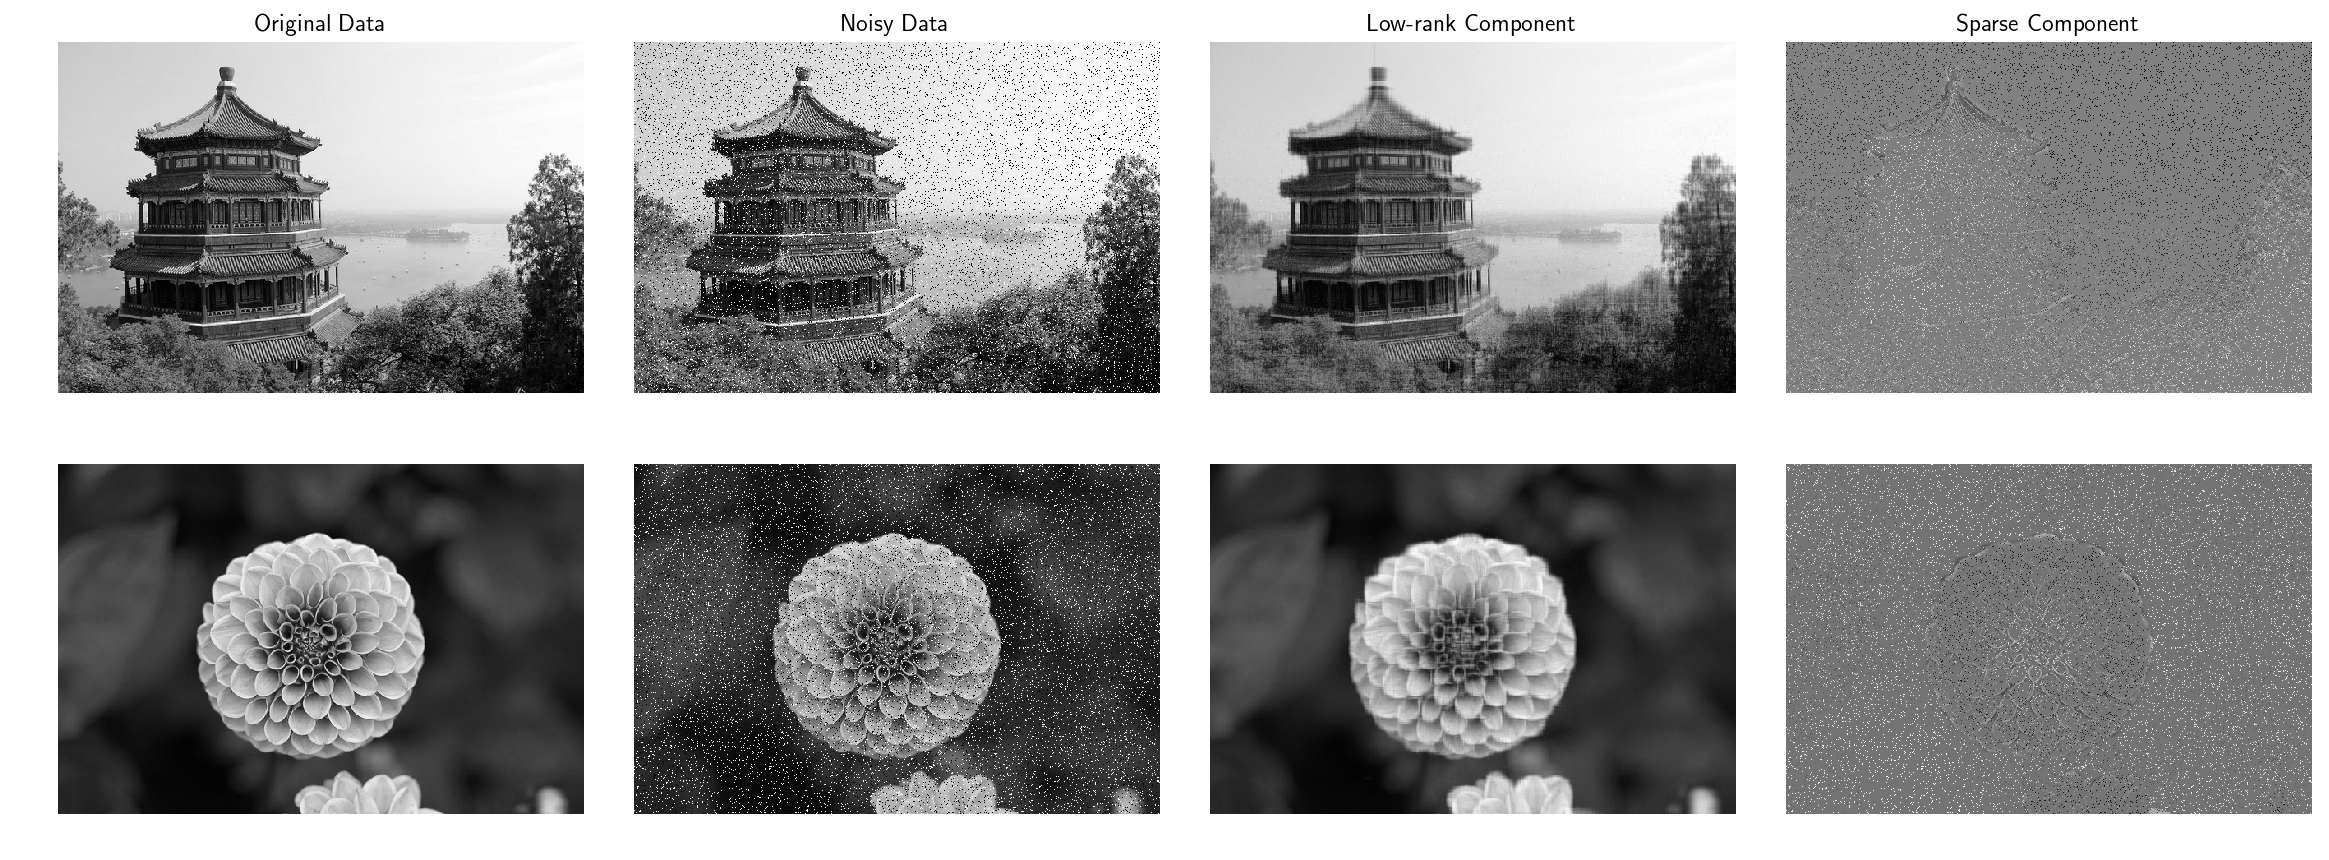

In [373]:
# Noise reduction via robust PCA
data = load_sample_images()
X = [color.rgb2gray(image) for image in data.images]
Y = [random_noise(x, mode='s&p', amount=0.1) for x in X]
L, S = zip(*[ialm(y) for y in Y])
fig = plt.figure(figsize=(16, 6))

for i in range(2):
    ax = fig.add_subplot(2, 4, 4 * i + 1)
    ax.imshow(X[i], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Original Data')
    ax = fig.add_subplot(2, 4, 4 * i + 2)
    ax.imshow(Y[i], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Noisy Data')
    ax = fig.add_subplot(2, 4, 4 * i + 3)
    ax.imshow(L[i], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Low-rank Component')
    ax = fig.add_subplot(2, 4, 4 * i + 4)
    ax.imshow(S[i], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Sparse Component')
        
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.savefig('/Users/btang/Desktop/blog/assets/posts/robust-pca/noise-reduction.png', bbox_inches='tight', dpi=300)

### Shadow Removal with Robust PCA

In this example, we use the Extended Yale Face Dataset B where the face images are expanded into column vectors and vertically concatenated to form an observation matrix for each person. The face images have resolution $192\times 168$ pixels, and each person has about $65$ face images. As usual, the backgrounds are detected automatically via the low-rank components, which retain pretty much all of the visual features under various settings of shadows in this case.

Iteration 0: Residual norm is 2.928279
Iteration 10: Residual norm is 0.050141
Iteration 20: Residual norm is 0.009585
Iteration 30: Residual norm is 0.001035
Iteration 40: Residual norm is 0.000115
Iteration 50: Residual norm is 0.000013
Converged at iteration 52
Iteration 0: Residual norm is 2.999341
Iteration 10: Residual norm is 0.048843
Iteration 20: Residual norm is 0.009647
Iteration 30: Residual norm is 0.001058
Iteration 40: Residual norm is 0.000115
Iteration 50: Residual norm is 0.000013
Converged at iteration 52


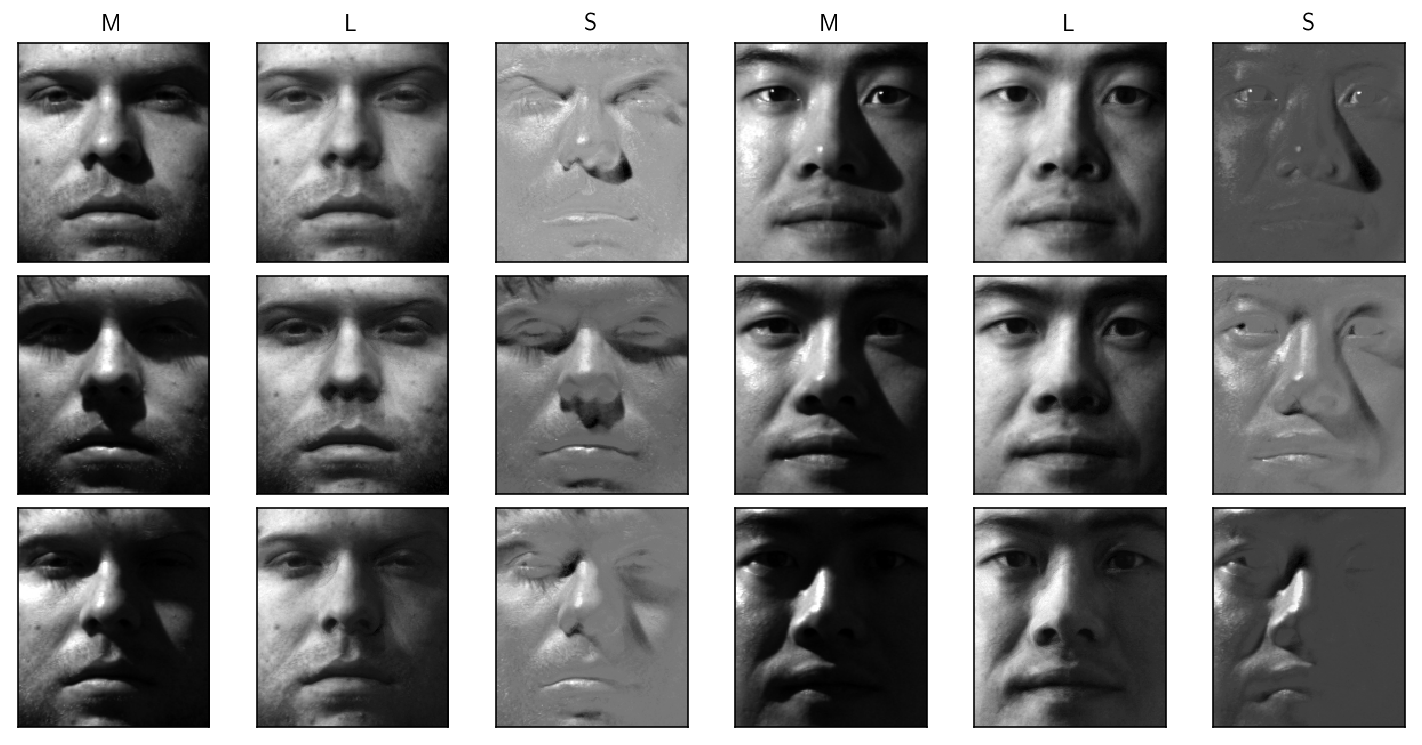

In [404]:
def load_images(path, suffix):
    names = sorted(glob(path + '/*.' + suffix))
    size = imread(names[0], as_grey=True).shape
    return np.column_stack([imread(name, as_grey=True).reshape(-1, 1) for name in names]), size

M1, size1 = load_images('input/yale-1/', 'pgm')
M2, size2 = load_images('input/yale-2', 'pgm')
L1, S1 = ialm(M1, tol=1e-5)
L2, S2 = ialm(M2, tol=1e-5)

def plot_images(M1, L1, S1, indices1, M2, L2, S2, indices2, size):
    n_rows = len(indices1)
    fig = plt.figure(figsize=(10, 5))

    for i, (index1, index2) in enumerate(zip(indices1, indices2)):
        ax = fig.add_subplot(n_rows, 6, 6 * i + 1, xticks=[], yticks=[])
        ax.imshow(M1[:, index1].reshape(size), cmap='gray')
        if i == 0:
            ax.set_title('M')
        ax = fig.add_subplot(n_rows, 6, 6 * i + 2, xticks=[], yticks=[])
        ax.imshow(L1[:, index1].reshape(size), cmap='gray')
        if i == 0:
            ax.set_title('L')
        ax = fig.add_subplot(n_rows, 6, 6 * i + 3, xticks=[], yticks=[])
        ax.imshow(S1[:, index1].reshape(size), cmap='gray')
        if i == 0:
            ax.set_title('S')
    
        ax = fig.add_subplot(n_rows, 6, 6 * i + 4, xticks=[], yticks=[])
        ax.imshow(M2[:, index2].reshape(size), cmap='gray')
        if i == 0:
            ax.set_title('M')
        ax = fig.add_subplot(n_rows, 6, 6 * i + 5, xticks=[], yticks=[])
        ax.imshow(L2[:, index2].reshape(size), cmap='gray')
        if i == 0:
            ax.set_title('L')
        ax = fig.add_subplot(n_rows, 6, 6 * i + 6, xticks=[], yticks=[])
        ax.imshow(S2[:, index2].reshape(size), cmap='gray')
        if i == 0:
            ax.set_title('S')
    return fig

fig = plot_images(M1, L1, S1, [16, 17, 24], M2, L2, S2, [21, 24, 30], size1)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.savefig('/Users/btang/Desktop/blog/assets/posts/robust-pca/shadow-removal.png', bbox_inches='tight', dpi=300)

### Background Subtraction

Though the aforementioned applications are great, it is our initial problem of background subtraction that is most interesting. More specifically, we consider $132$ consecutive video frames of size $288 \times 344$ extracted from the [ImageLab website](http://imagelab.ing.unimore.it/visor/video_details.asp?idvideo=194). As usual, these frames are then concatenated to form an observation matrix of size $99072 \times 132$. [Figure 4](#fig:unimore-pspg) shows 5 different frames and their decomposed components after they are converted back into images.

Iteration 0: Residual norm is 3.407587
Iteration 10: Residual norm is 0.057746
Iteration 20: Residual norm is 0.012049
Iteration 30: Residual norm is 0.001365
Iteration 40: Residual norm is 0.000133
Iteration 50: Residual norm is 0.000016
Converged at iteration 53
Y 0.00300703265205


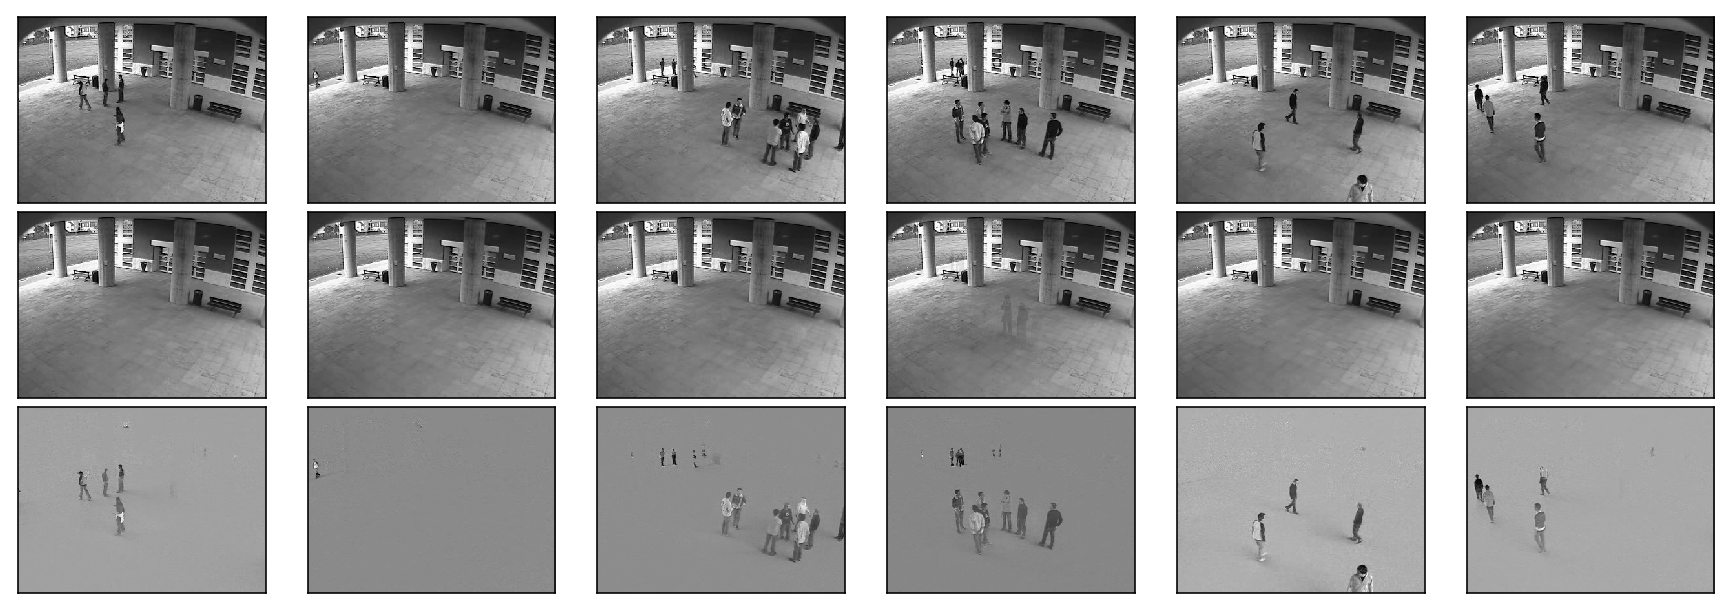

In [76]:
# Load images from a video and perform background subtraction
M, size = load_images('input/camera/', 'png')
M = np.random.permutation(M.T).T
L, S = ialm(M, tol=1e-5)

def plot_images(M, L, S, size, indices, n_columns):
    n_rows = np.ceil(len(indices) / n_columns)
    fig = plt.figure(figsize=(2 * n_columns, 2 * n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=2, hspace=0.05, wspace=0.05)

    for i, e in enumerate(indices):
        ax = fig.add_subplot(3 * n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(M[:, e].reshape(size), cmap='gray')
        ax = fig.add_subplot(3 * n_rows, n_columns, n_columns + i + 1, xticks=[], yticks=[])
        ax.imshow(L[:, e].reshape(size), cmap='gray')
        ax = fig.add_subplot(3 * n_rows, n_columns, 2 * n_columns + i + 1, xticks=[], yticks=[])
        ax.imshow(S[:, e].reshape(size), cmap='gray')
        
plot_images(M, L, S, size, range(0, M.shape[1], 20), 8)

It appears that the backgrounds are well separated from the people regardless of where they stand, although the estimated foregrounds contain some small non-human features. The task may seem trivial, but is is so easy to have some ghosts lurking in the background if it is not done right.

So far, robust PCA has shown convincing results for different kinds of tasks and datasets. However, it is important to remember that matrix computations can be very expensive and time-consuming if we have lots of data. Also, the algorithm presented earlier do not show empirical robustness to gradual changes in the background, like camera rotations. Yet, let's take a moment to enjoy what we have accomplished with an awesome video simply made by putting frames together.

In [ ]:
def make_video(M, L, S, size, cache_path='output/frame', video_path='output/video/unimore.mp4'):
    if os.path.exists(cache_path):
        shutil.rmtree(cache_path)
    os.mkdir(cache_path)
    
    for i in range(M.shape[1]):
        fig = plt.figure(figsize=(20, 30))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=2, hspace=0.05, wspace=0.05)
        
        ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
        ax.imshow(M[:, i].reshape(size), cmap='gray')
        ax.set_title('Input Data')
        
        ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
        ax.imshow(L[:, i].reshape(size), cmap='gray')
        ax.set_title('Low-rank Component')      
        
        ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
        ax.imshow(S[:, i].reshape(size), cmap='gray')
        ax.set_title('Sparse Component')        
        fig.tight_layout()
        
        fname = '%s/frame-%d.png' % (cache_path, i)
        fig.savefig(fname, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()
        if i % 20 == 0:
            print('Finish making %d frames' % i)
            
    os.system("ffmpeg -y -r 1 -i '%s/tmp%%d.png' -c:v libx264 " % cache_path + "-s 1920x1080 -pix_fmt yuv420p %s" % video_path)

def html_video(fname, frames):
    framesz = 250
    info = {"mp4": {"ext":"mp4", "encoded": '', "size":(frames * framesz, framesz)}}
    html_output = []
    for k in info.keys():
        f = open("%s.%s" % (fname, info[k]["ext"]), "rb").read()
        encoded = b64encode(f).decode('ascii')
        video_tag = '<video width="1000" height="300" autoplay="autoplay" loop src="data:video/%s;base64,%s">' % (k, encoded)
        html_output.append(video_tag)
    return HTML(data=''.join(html_output))

make_video(M, L, S, size)
html_video('output/ialm/video/unimore', 1)

<video width="60%" controls="controls" style="margin-top: 20px; margin-bottom:20px"><source src="images/robust-pca/unimore.mp4" type="video/mp4"></video>

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())